<div style="text-align: center; vertical-align: middle;">

# IMAGEN


</div>

**LIBRERIAS**

In [1]:
import os
import numpy as np
import cv2
import matplotlib.pylab as plt
from sklearn.cluster import KMeans
import joblib
from scipy.spatial.distance import cdist
import math
import librosa
import librosa.display
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import sounddevice as sd
from scipy.signal import butter, lfilter
import soundfile as sf

**SHELFS**

In [2]:
image_path      = '../../dataset/images'
shelfs_path     = os.path.join(image_path, 'test')
shelf_names     = ['shelf1', 'shelf2', 'shelf3', 'shelf4']
training_data   = '../images/kmeans/training_data.pkl'

**DICCIONARIO DE IMAGENES RAW**

In [3]:
shelf_files = dict()
for shelf in shelf_names:
    shelf_dir      = os.path.join(shelfs_path, shelf)
    shelf_original = os.path.join(shelf_dir, 'original')
    image_files    = os.listdir(shelf_original)

    shelf_files[shelf] = os.path.join(shelf_original, image_files[0])

**PROCESAMIENTO DE LAS IMÁGENES**

In [4]:
def get_light_background(mask, f = 20, p = 0.75):
    height, width = mask.shape
    cluster_size  = min([height, width])//f
    cluster       = np.ones((cluster_size, cluster_size), np.uint8)

    # Corners
    corner1 = np.bitwise_and(cluster, mask[:cluster_size,  :cluster_size])
    corner2 = np.bitwise_and(cluster, mask[:cluster_size:, -cluster_size:])
    corner3 = np.bitwise_and(cluster, mask[-cluster_size:, :cluster_size])
    corner4 = np.bitwise_and(cluster, mask[-cluster_size:, -cluster_size:])
    corners = [corner1, corner2, corner3, corner4]

    # Sides
    limitw1 = (width - cluster_size)//2
    limitw2 = (width + cluster_size)//2
    limith1 = (height - cluster_size)//2
    limith2 = (height + cluster_size)//2
    
    side1   = np.bitwise_and(cluster, mask[:cluster_size, limitw1:limitw2])
    side2   = np.bitwise_and(cluster, mask[limith1:limith2, :cluster_size])
    side3   = np.bitwise_and(cluster, mask[limith1:limith2, -cluster_size:])
    side4   = np.bitwise_and(cluster, mask[-cluster_size:, limitw1:limitw2])
    sides   = [side1, side2, side3, side4] 
    
    # Determining the type of background
    edges            = corners + sides
    light_background = sum(np.count_nonzero(edge) for edge in edges) > p*8*(cluster_size**2)

    # Inverting if dark background
    if light_background:
        return np.bitwise_not(mask)
    return mask    

In [5]:
for shelf, file in shelf_files.items():
    # BGR image
    image = cv2.imread(file)

    # Dimenssions
    height, width, _ = image.shape
    
    # Pixel data vector
    data_vector = np.zeros((height * width, 4))

    # Obtener matrices del espacio de colores
    rgb_matrix = image.reshape((-1, 3))
    hsv_matrix = cv2.cvtColor(image, cv2.COLOR_BGR2HSV).reshape((-1, 3))
    lab_matrix = cv2.cvtColor(image, cv2.COLOR_BGR2LAB).reshape((-1, 3))

    # Asignar a la matriz de datos
    # Conservamos el canal G, S, A y B
    data_vector[:, 0]  = rgb_matrix[:, 2]
    data_vector[:, 1]  = hsv_matrix[:, 1]
    data_vector[:, 2:] = lab_matrix[:, 1:]

    # Segmentamos la imagen con los vectores obtenidos pos cada pixel
    kmeans = KMeans(n_clusters = 2, n_init = 10, random_state=42)  # 2 Clusters. Background and fruit
    kmeans.fit(data_vector)

    # Get clusters labels
    labels = kmeans.labels_

    # kmeans_mask
    kmeans_mask = labels.reshape(height, width)
    kmeans_mask = kmeans_mask.astype(np.uint8) * 255

    # Determinación del tipo de fondo de la máscara
    kmeans_mask = get_light_background(kmeans_mask)

    # Erosion y dilataciòn sobre la màscara
    erosion_size      = min([height, width])//200
    dilatacion_size   = min([height, width])//80
    kernel_erosion    = np.ones((erosion_size,erosion_size), np.uint8)
    eroded            = cv2.erode(kmeans_mask, kernel_erosion, iterations = 1)
    kernel_dilatacion = np.ones((dilatacion_size,dilatacion_size), np.uint8)
    kmeans_mask       = cv2.dilate(eroded, kernel_dilatacion, iterations  = 2)

    # Encontrar contornos
    kmeans_cnt, _ = cv2.findContours(kmeans_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    kmeans_cnt    = max(kmeans_cnt, key = cv2.contourArea)

    # Contorno aproximado
    epsilon       = 0.001 * cv2.arcLength(kmeans_cnt, True)
    kmeans_cnt    = cv2.approxPolyDP(kmeans_cnt, epsilon, True)
    kmeans_cnt    = (kmeans_cnt,)

    # Template
    tkmeans       = np.zeros((height, width), dtype=np.uint8)

    # Dibujar
    cv2.drawContours(tkmeans, kmeans_cnt, -1, 255, thickness = cv2.FILLED)

    # Guardar mascara
    cv2.imwrite(os.path.join(shelfs_path, f"{shelf}/processed/{os.path.basename(file)}"), tkmeans)

**DICCIONARIO DE MÁSCARAS**

In [6]:
shelf_masks = dict()
for shelf in shelf_names:
    shelf_dir     = os.path.join(shelfs_path, shelf)
    shelf_mask    = os.path.join(shelf_dir, 'processed')
    mask_files    = os.listdir(shelf_mask)

    shelf_masks[shelf] = os.path.join(shelf_mask, mask_files[0])

**RANGOS DE COLOR**

In [7]:
lower_red_2 = np.array([170, 60, 60])
upper_red_2 = np.array([179, 255, 255])

lower_red_1 = np.array([0, 60, 60])
upper_red_1 = np.array([8, 255, 255])

lower_orange = np.array([8, 120, 80])
upper_orange = np.array([21, 255, 255])

lower_yellow = np.array([21, 50, 80])
upper_yellow = np.array([25, 255, 255])

lower_green = np.array([25, 40, 40])
upper_green = np.array([100, 255, 255])

**EXTRACCIÓN DE CARACTERÍSTICAS**

In [8]:
conversion_color = {'V' :-20, 'R' : -10, 'A' : 10, 'N' : 20}
image_features   = dict.fromkeys(shelf_names)

for shelf, image_file, mask_file in zip(shelf_files.keys(), shelf_files.values(), shelf_masks.values()):
    # Leer la imagen y la máscara
    image = cv2.imread(image_file)
    mask  = cv2.imread(mask_file, cv2.IMREAD_GRAYSCALE)

    # Convertir la imagen de BGR a HSV
    hsv_image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

    # Aplicar la máscara
    fruit = cv2.bitwise_and(hsv_image, hsv_image, mask=mask)

    #---------------Extracción de los momentos de Hu----------------------

    # Encontrar el rectángulo delimitador de la fruta
    (x, y, w, h) = cv2.boundingRect(mask)

    # Recortar la imagen original para obtener solo la región de la fruta
    trimed  = fruit[y:y + h, x:x + w]

    # Convertir la imagen a escala de grises si es necesario
    trimed_gray = cv2.cvtColor(trimed, cv2.COLOR_BGR2GRAY)

    # Calcular los momentos de la imagen
    momentos = cv2.moments(trimed_gray)

    # Calcular los momentos de Hu
    momentos_hu = cv2.HuMoments(momentos)

    # Aplicar logaritmo a los momentos de Hu para mejorar la escala
    log_moments_hu = -np.sign(momentos_hu) * np.log10(np.abs(momentos_hu))
    moments = log_moments_hu.reshape(-1)

    #-----------------------Extracción de color-------------------------
    conteo = {
        'V' : np.sum(np.all(np.logical_and(lower_green  <= fruit, fruit <= upper_green), axis=-1)),
        'R1': np.sum(np.all(np.logical_and(lower_red_1  <= fruit, fruit <= upper_red_1), axis=-1)),
        'R2': np.sum(np.all(np.logical_and(lower_red_2  <= fruit, fruit <= upper_red_2), axis=-1)),
        'A' : np.sum(np.all(np.logical_and(lower_yellow <= fruit, fruit <= upper_yellow), axis=-1)),
        'N' : np.sum(np.all(np.logical_and(lower_orange <= fruit, fruit <= upper_orange), axis=-1))
    }
    conteo_por_rango = {
        'V': conteo['V'],
        'R': conteo['R1'] + conteo['R2'],
        'A': conteo['A'],
        'N': conteo['N']
    }

    sorted_conteo = sorted(conteo_por_rango.items(), key=lambda x: x[1], reverse=True)

    # Obtener el segundo elemento más grande
    segundo_mas_grande = sorted_conteo[1]

    # Obtener la etiqueta y el valor del segundo elemento más grande
    etiqueta_segundo_mas_grande = segundo_mas_grande[0]
    valor_segundo_mas_grande    = segundo_mas_grande[1]

    # Obtener la etiqueta basándose en el rango con el mayor conteo
    etiqueta = max(conteo_por_rango, key = conteo_por_rango.get)

    # Se usa el hecho de que a excepción de las manzanas, el resto de las frutas tienen poco rojo
    if (etiqueta_segundo_mas_grande == 'R')and(valor_segundo_mas_grande > 0.35*conteo_por_rango[etiqueta]):
        etiqueta = 'R'

    color = conversion_color[etiqueta]

    #-----------------Vector de características----------------------
    image_features[shelf] = np.append(moments[2:4], color)
    

**RECUPERAMOS LOS CENTROIDES Y APLICACIÓN DE KNN**

In [9]:
def knn(training, test, k_n):
    X           = np.concatenate([v for v in training.values()], axis = 0)
    y           = np.concatenate([[k] * v.shape[0] for k, v in training.items()])
    dist        = cdist(test, X)
    sorted_ind  = np.argsort(dist, axis = 1)
    sorted_k    = sorted_ind[:, 0:k_n]
    predicted   = []
    
    for row in sorted_k:
        labels     = list(y[row])
        prediction = max(set(labels), key = labels.count)
        predicted.append(prediction)
    return predicted

In [10]:
data              = joblib.load(training_data)
centroids         = data['centroids']
prediction        = knn(centroids, np.vstack(list(image_features.values())), 1)

**CLASIFICACIÓN DE LAS FRUTAS EN LOS ESTANTES**

In [11]:
shelfs = dict(zip(image_features.keys(), prediction))

<div style="text-align: center; vertical-align: middle;">

# AUDIO


</div>


**RUTAS, TIPOS DE FRUTAS Y MODELO**

In [12]:
fruit_types      = ['pera', 'banana', 'manzana', 'naranja']
dataset_path     = '../../dataset/audios/test'
original_path    = os.path.join(dataset_path, 'original')
processed_path   = os.path.join(dataset_path, 'processed')
model_file       = '../audio/knn/model.pkl'
model            = dict.fromkeys(['pca', 'features', 'scaler'])

**PARAMETROS DEL AUDIO**

In [13]:
FRAME_SIZE = 512# In the documentation says it's convenient for speech.C
HOP_SIZE   = int(FRAME_SIZE/2)

**FUNCIONES GENERALES DE AUDIO**

In [14]:
def load_audio(audiofile):
    test_audio, sr = librosa.load(audiofile, sr = None)
    duration = librosa.get_duration(filename=audiofile, sr=sr)
    return test_audio, sr, duration

**FILTERS**

In [15]:
def band_pass_filter(signal, sr, low_cutoff, high_cutoff):
    b, a = butter(N=3, Wn = [low_cutoff, high_cutoff], btype='band', fs=sr)
    return lfilter(b, a, signal)

**PROCCESSING OF THE AUDIO FILES FUNCTIONS**

*Processing*

In [16]:
def spectral_flux(signal):

    # Calcular el espectrograma de magnitudes
    spectrogram = np.abs(librosa.stft(signal, n_fft = FRAME_SIZE, hop_length = HOP_SIZE))

    # Calcular el flujo espectral
    spectral_flux_values = np.sum(np.diff(spectrogram, axis=1)**2, axis=0)

    return spectral_flux_values

In [17]:
def process(audio_in, audio_out, rms_umbral = 0.043, flux_umbral = 0.096):
    signal, sr, _ = load_audio(audio_in)

    rms = librosa.feature.rms(y = signal, frame_length = FRAME_SIZE, hop_length = HOP_SIZE)
    rms /= np.max(np.abs(rms))
    trms = librosa.times_like(rms, sr = sr, hop_length = HOP_SIZE, n_fft = FRAME_SIZE)
    trms /= trms[-1]

    flux = spectral_flux(signal)
    flux /= np.max(np.abs(flux))
    fluxframes = range(len(flux))
    tflux = librosa.frames_to_time(fluxframes, hop_length=HOP_SIZE, n_fft = FRAME_SIZE)
    tflux /= tflux[-1]
                
    left_index = np.argmax(np.abs(flux) > flux_umbral)
    rigth_index = len(flux) - 1 - np.argmax(np.abs(np.flip(flux)) > flux_umbral)

    tsignal = librosa.times_like(signal, sr = sr, hop_length=HOP_SIZE, n_fft=FRAME_SIZE)
    tsignal /= tsignal[-1]

    flag      = False
    pad_left  = 0
    pad_rigth = 0
    flag_left  =  False
    flag_rigth =  False
                
    while not flag:
        if rms[0, left_index] > rms_umbral:
            if left_index > pad_left + 15:
                rms_left = left_index - np.argmax(np.flip(np.abs(rms[0, :left_index]) < rms_umbral))
                if rms_left <= 0:
                    rms_left = left_index
                flag_left = True
            else:
                pad_left += 15
                left_index = pad_left + np.argmax(np.abs(flux[pad_left:]) > flux_umbral)
        else:
                rms_left = left_index
                flag_left = True

        if rms[0, rigth_index] > rms_umbral:
            if rigth_index < (len(flux) - 1 - pad_rigth-15):
                rms_rigth = rigth_index + np.argmax(np.abs(rms[0, rigth_index:]) < rms_umbral)
                if rms_rigth >= len(flux):
                    rms_rigth = rigth_index
                flag_rigth = True
            else:
                pad_rigth += 15
                rigth_index = len(flux[:-pad_rigth]) - 1 - np.argmax(np.flip(np.abs(flux[:-pad_rigth]) > flux_umbral))                               
        else:
            rms_rigth = rigth_index
            flag_rigth = True

        flag = flag_left and flag_rigth

    left_index  = min(left_index, rms_left)
    rigth_index = max(rigth_index, rms_rigth)
    mask        = tsignal >= tflux[left_index]
    ttrimed     = tsignal[mask]
    trimed      = signal[mask]
    mask        = ttrimed <= tflux[rigth_index]
    ttrimed     = ttrimed[mask]
    trimed      = trimed[mask]
    
    sf.write(audio_out, trimed, sr)

**FEATURES EXTRACTION**

*Features extraction functions*

In [18]:
def calculate_split_frequency_bin(split_frequency, sample_rate, num_frequency_bins):
    """Infer the frequency bin associated to a given split frequency."""
    
    frequency_range = sample_rate / 2
    frequency_delta_per_bin = frequency_range / num_frequency_bins
    split_frequency_bin = math.floor(split_frequency / frequency_delta_per_bin)
    return int(split_frequency_bin)

In [19]:
def band_energy_ratio(spectrogram, split_frequency, sample_rate):
    """Calculate band energy ratio with a given split frequency."""
    
    split_frequency_bin = calculate_split_frequency_bin(split_frequency, sample_rate, len(spectrogram[0]))
    band_energy_ratio = []
    
    # calculate power spectrogram
    power_spectrogram = np.abs(spectrogram) ** 2
    power_spectrogram = power_spectrogram.T
    
    # calculate BER value for each frame
    for frame in power_spectrogram:
        sum_power_low_frequencies = frame[:split_frequency_bin].sum()
        sum_power_high_frequencies = frame[split_frequency_bin:].sum()
        band_energy_ratio_current_frame = sum_power_low_frequencies / (sum_power_high_frequencies + sum_power_low_frequencies)
        band_energy_ratio.append(band_energy_ratio_current_frame)
    
    return np.array(band_energy_ratio)

In [20]:
def rms(signal, frames, hop):
    return librosa.feature.rms(y=signal, frame_length = frames, hop_length = hop)

*Function to get the features*

In [21]:
def get_features(signal, sr):
    feature = np.empty((1, 0))

    # BER
    spec = librosa.stft(signal, n_fft = FRAME_SIZE, hop_length = HOP_SIZE)
    # max
    split_frequency = 600
    BER  = band_energy_ratio(spec, split_frequency, sr)
    feat = np.max(np.abs(BER))
    feature = np.append(feature, feat)
    # min
    # 1
    split_frequency = 1900
    BER  = band_energy_ratio(spec, split_frequency, sr)
    feat = np.min(np.abs(BER))
    feature = np.append(feature, feat)
    # 2
    split_frequency = 5000
    BER  = band_energy_ratio(spec, split_frequency, sr)
    feat = np.min(np.abs(BER))
    feature = np.append(feature, feat)
    # 3
    split_frequency = 9000
    BER  = band_energy_ratio(spec, split_frequency, sr)
    feat = np.min(np.abs(BER))
    feature = np.append(feature, feat)
    # std
    # 1
    split_frequency = 8000
    BER  = band_energy_ratio(spec, split_frequency, sr)
    BER /= np.max(np.abs(BER))
    feat = np.std(BER)/np.mean(np.abs(BER))
    feature = np.append(feature, feat)
    # 2
    split_frequency = 1000
    BER  = band_energy_ratio(spec, split_frequency, sr)
    BER /= np.max(np.abs(BER))
    feat = np.std(BER)/np.mean(np.abs(BER))
    feature = np.append(feature, feat)

    #ZCR
    cutoff = 5000
    cuton = 1000
    filtered = band_pass_filter(signal, sr, cuton, cutoff)
    zcr = librosa.feature.zero_crossing_rate(filtered, frame_length=FRAME_SIZE, hop_length=HOP_SIZE)[0]
    zcr /= np.max(np.abs(zcr))
    # mean
    feat = np.mean(zcr)
    feature = np.append(feature, feat)
    # maximum
    cutoff = 10000
    cuton = 10
    filtered = band_pass_filter(signal, sr, cuton, cutoff)
    zcr = librosa.feature.zero_crossing_rate(filtered, frame_length=FRAME_SIZE, hop_length=HOP_SIZE)[0]
    feat = np.max(np.abs(zcr))
    feature = np.append(feature, feat)
    # std
    cutoff = 10000
    cuton  = 20
    filtered = band_pass_filter(signal, sr, cuton, cutoff)
    zcr = librosa.feature.zero_crossing_rate(filtered, frame_length=FRAME_SIZE, hop_length=HOP_SIZE)[0]
    feat = np.std(zcr)/np.mean(np.abs(zcr))
    feature = np.append(feature, feat)
    # mean local
    cutoff = 5000
    cuton = 1000
    filtered = band_pass_filter(signal, sr, cuton, cutoff)
    zcr = librosa.feature.zero_crossing_rate(filtered, frame_length=FRAME_SIZE, hop_length=HOP_SIZE)[0]
    zcr /= np.max(np.abs(zcr))
    feat = np.mean(zcr[((len(zcr)*3)//14 - 5) : ((len(zcr)*3)//14 + 5)])
    feature = np.append(feature, feat)
    # local max
    cutoff = 10000
    cuton = 10
    filtered = band_pass_filter(signal, sr, cuton, cutoff)
    zcr = librosa.feature.zero_crossing_rate(filtered, frame_length=FRAME_SIZE, hop_length=HOP_SIZE)[0]
    feat = np.max(zcr[((len(zcr)*3)//4 - 10) : ((len(zcr)*3)//4 + 10)])
    feature = np.append(feature, feat)

    # Roll off
    cuton = 100
    cutoff = 8500
    filtered = band_pass_filter(signal, sr, cuton, cutoff)
    roll_off = librosa.feature.spectral_rolloff(y=filtered, sr=sr, n_fft=FRAME_SIZE, hop_length=HOP_SIZE, roll_percent=0.28)[0]
    roll_off /= np.max(np.abs(roll_off))
    # mean
    feat = np.mean(np.abs(roll_off))
    feature = np.append(feature, feat)
    # max
    cuton = 100
    cutoff = 8500
    filtered = band_pass_filter(signal, sr, cuton, cutoff)
    roll_off = librosa.feature.spectral_rolloff(y=filtered, sr=sr, n_fft=FRAME_SIZE, hop_length=HOP_SIZE, roll_percent=0.55)[0]
    feat = np.max(np.abs(roll_off))
    feature = np.append(feature, feat)
    # std
    cutoff = 8500
    cuton = 50
    filtered = band_pass_filter(signal, sr, cuton, cutoff)
    roll_off = librosa.feature.spectral_rolloff(y=filtered, sr=sr, n_fft=FRAME_SIZE, hop_length=HOP_SIZE, roll_percent=0.28)[0]
    roll_off /= np.max(np.abs(roll_off))
    feat = np.std(np.abs(roll_off))/np.mean(np.abs(roll_off))
    feature = np.append(feature, feat)

    #MFCCS
    n_mfcc = 4
    # 1
    cuton = 500
    cutoff = 5000
    filtered = band_pass_filter(signal, sr, cuton, cutoff)
    mfccs = librosa.feature.mfcc(y = signal, sr=sr, n_mfcc = n_mfcc, n_fft = FRAME_SIZE, hop_length = HOP_SIZE)
    feat = np.max(mfccs, axis = 1)
    feature = np.append(feature, feat[3])
    
    # 2
    cuton = 10
    cutoff = 8000
    filtered = band_pass_filter(signal, sr, cuton, cutoff)
    mfccs = librosa.feature.mfcc(y = filtered, sr=sr, n_mfcc = n_mfcc, n_fft = FRAME_SIZE, hop_length = HOP_SIZE)
    mfccs /= np.max(np.abs(mfccs), axis = 1, keepdims=True)
    feat = np.std(np.abs(mfccs), axis = 1)/np.mean(np.abs(mfccs), axis = 1)
    feature = np.append(feature, feat[3])

    # 3
    cuton = 10
    cutoff = 8000
    filtered = band_pass_filter(signal, sr, cuton, cutoff)
    mfccs = librosa.feature.mfcc(y = filtered, sr=sr, n_mfcc = n_mfcc, n_fft = FRAME_SIZE, hop_length = HOP_SIZE)
    mfccs /= np.max(np.abs(mfccs), axis = 1, keepdims=True)
    mfccs = mfccs[:, ((mfccs.shape[1]*4) // 5 - 10):((mfccs.shape[1]*4) //5 + 10)]
    feat = np.std(np.abs(mfccs), axis=1) / np.mean(np.abs(mfccs), axis=1)
    feature = np.append(feature, feat[1])

    #envelope
    env = rms(signal, FRAME_SIZE, HOP_SIZE)
    env = env.reshape(-1,)
    selected = np.linspace(0, len(env) - 1, 30, dtype=int)
    env = env[selected]
    feat = env[11]
    feature = np.append(feature, feat)
    feat = env[12]
    feature = np.append(feature, feat)

    return feature

**AUDIO RECORGING**

In [22]:
duration = 2.5      # Duración de la grabación en segundos
fs       = 48000    # Frecuencia de muestreo en Hz

input('Presione ENTER cuando este listo para grabar')
print("Grabando...")

data = sd.rec(int(duration * fs), samplerate = fs, channels = 1, dtype = 'int16')
sd.wait()
print("Grabación completa.")

orden = os.path.join(original_path, f"test{len(os.listdir(original_path)) + 1}.wav")
sf.write(orden, data, fs)

Grabando...
Grabación completa.


**PROCESSING**

In [23]:
processed_order = os.path.join(processed_path, f"test{len(os.listdir(processed_path)) + 1}.wav")
process(orden, processed_order)

C:\Users\Juan\AppData\Local\Temp\ipykernel_5652\1587896153.py:3: FutureWarning: get_duration() keyword argument 'filename' has been renamed to 'path' in version 0.10.0.
	This alias will be removed in version 1.0.
  duration = librosa.get_duration(filename=audiofile, sr=sr)


**FEATURE EXTRACTION**

In [24]:
signal, sr, _ = load_audio(processed_order)
feature       = get_features(signal, sr)
test_features = feature.reshape(1, -1)

C:\Users\Juan\AppData\Local\Temp\ipykernel_5652\1587896153.py:3: FutureWarning: get_duration() keyword argument 'filename' has been renamed to 'path' in version 0.10.0.
	This alias will be removed in version 1.0.
  duration = librosa.get_duration(filename=audiofile, sr=sr)
c:\Users\Juan\AppData\Local\Programs\Python\Python311\Lib\site-packages\librosa\feature\spectral.py:2143: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  mel_basis = filters.mel(sr=sr, n_fft=n_fft, **kwargs)


**LOAD THE REDUCED MODEL**

In [25]:
model        = joblib.load(model_file)
reduced:dict = model['features']
pca          = model['pca']
scaler       = model['scaler']

**TRANSFORM**

In [26]:
scaled_test_features   = scaler.transform(test_features)
reduced_test           = pca.transform(scaled_test_features)

**PREDICTION**

In [33]:
prediction  = knn(reduced, reduced_test, 3)
place = [shelf for shelf, fruit in shelfs.items() if fruit in prediction]

**RESULTADO**

Se encontró una ['banana'] en el shelf1


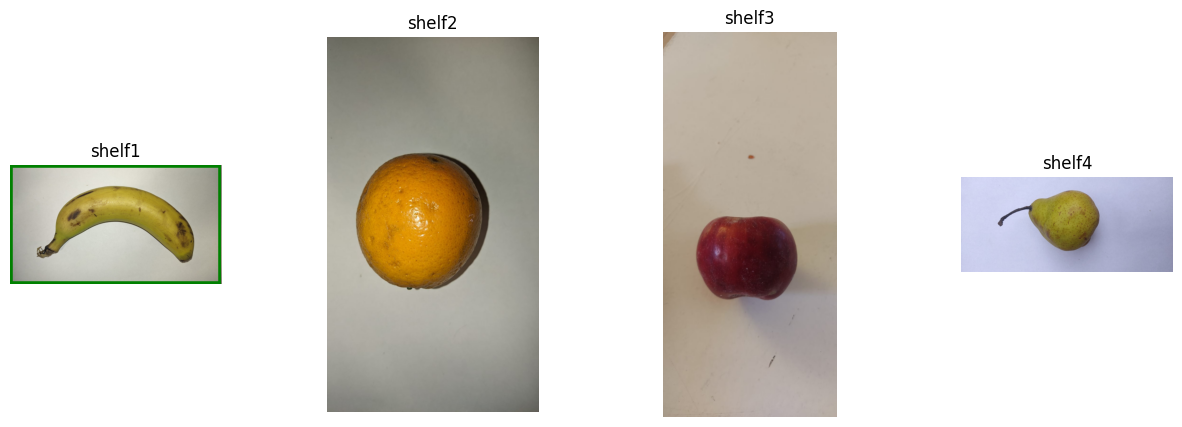

In [35]:
if len(place) == 0:
    print(f"No se encontró una {prediction} en ninguna de las 4 estanterías.")
elif len(place) == 1:
    print(f"Se encontró una {prediction} en el {place[0]}")
elif len(place) > 1:
    print(f"Se encontró una {prediction} en las siguientes estanterias: {place}")

fig, axs = plt.subplots(1, 4, figsize = (15, 5))
i = 0
for shelf, file in shelf_files.items():
    image = cv2.imread(file)
    axs[i].imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    axs[i].axis('off')
    axs[i].set_title(shelf)

    if shelf in place:
        h, w, _ = image.shape
        rect = plt.Rectangle((0, 0), w, h, linewidth = 4, edgecolor = 'green', facecolor = 'none')
        axs[i].add_patch(rect)
    i += 1

plt.subplots_adjust(wspace = 0.5)
plt.show()